In [267]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from decimal import *
import MySQLdb
import pandas.io.sql as psql
from MySQLdb.converters import conversions
from MySQLdb.constants import FIELD_TYPE
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from math import radians, sin, cos, sqrt, asin, pi, degrees
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import json
import scraperwiki
import scraperwiki
import json
import datetime
import keys

def GetRecentCrimeParsed(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+keys.spotcrime_secret
  s = scraperwiki.scrape(url)
  parsed_json = json.loads(s.partition('(')[-1].rpartition(')')[0])
  return parsed_json

def GetRecentCrimeString(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+keys.spotcrime_secret
  s = scraperwiki.scrape(url)
  return (s.partition('(')[-1].rpartition(')')[0])

def WriteRecentCrimes(start,step):
    filename="recent_crimes_json_"+str(start)+"_"+str(start+step)+".txt"
    with open(filename,"a") as myfile:
        myfile.write("[")
        myfile.write('{"eanid":'+str(df.ix[start].EANHotelID)+","+
            GetRecentCrimeString(df.ix[start].Longitude,df.ix[start].Latitude,radius)[1:]+'\n')
        for index, row in df[1:].iterrows():
            myfile.write(',{"eanid":'+str(row.EANHotelID)+","+
                         GetRecentCrimeString(row.Longitude,row.Latitude,radius)[1:]+'\n')
        myfile.write("]")
    return filename

def ViolentCrimeCount(lon,lat,radius):
  crime_json=GetRecentCrimeParsed(lon=lon,lat=lat,radius=radius)
  crime_list=[]
  for crime in crime_json['crimes']:
      crime_dict={'Date': 'no date','Assault': 0, 'Burglary': 0, 'Other': 0, 'Theft': 0, 'Vandalism': 0,
                  'Arrest': 0, 'Arson': 0, 'Robbery': 0, 'Shooting':0}
      crime_dict[crime['type']] = crime_dict.get(crime['type'], 0) + 1
      crime_dict['Date'] = datetime.datetime.strptime((crime['date'])[0:8], "%m/%d/%y").date()
      crime_list.append(crime_dict)
  try:
      testdf=DataFrame(crime_list)
      testdf=testdf.groupby(by=testdf.Date).sum()
      violent_list=['Arrest','Arson','Assault','Shooting','Robbery','Vandalism']
      count=0
      for crime in violent_list:
        count += testdf[crime].sum()
  except:
      count=0
  return count



conversions[FIELD_TYPE.DECIMAL] = float
conversions[FIELD_TYPE.NEWDECIMAL] = float

conn = MySQLdb.connect(user="root", host="localhost", db='eanprod', charset='utf8',unix_socket="/tmp/mysql.sock")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Select attractions and give them better categories

In [147]:
sql='SELECT * FROM pointsofinterestcoordinateslist WHERE RegionNameLong LIKE "%California, United States of America%";'
attractions = DataFrame(psql.read_sql(sql, conn))

attractions.SubClassification[attractions.SubClassification=='anchor']='marine'
attractions.SubClassification[attractions.SubClassification=='tree']='park'
attractions.SubClassification[attractions.SubClassification=='icecream']='amusement'
attractions.SubClassification[attractions.SubClassification=='sunglass']='beach'
attractions.SubClassification[attractions.SubClassification=='civic']='cityscape'
attractions.SubClassification[attractions.SubClassification=='stadius']='sports'

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [148]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth 
    # Use 3956 for miles, 6371 for kilometers
    return c * r

## compute distance matrix

In [149]:
X=attractions[:][['Latitude', 'Longitude']].values
N = X.shape[0]
distance_matrix = zeros((N, N))
for i in xrange(N):
    for j in xrange(i):
        lati, loni = X[i]
        latj, lonj = X[j]
        distance_matrix[i, j] = haversine(loni, lati, lonj, latj)
        distance_matrix[j, i] = distance_matrix[i, j]

## compute DBSCAN clusters

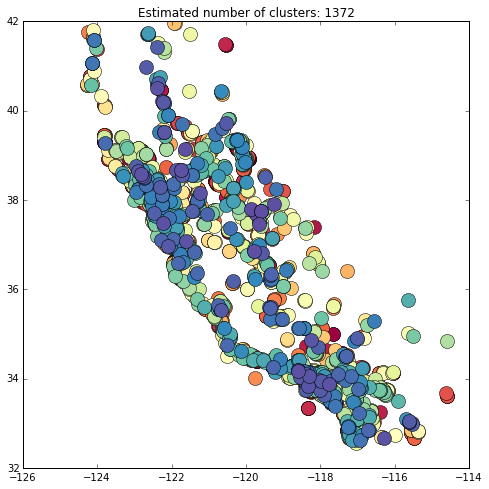

In [245]:
dbsc = DBSCAN(eps=1., min_samples=1,metric='precomputed').fit(distance_matrix)
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
labels = dbsc.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

1372

In [261]:
from __future__ import print_function

from bokeh.browserlib import view
from bokeh.document import Document
from bokeh.embed import file_html
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxSelectTool,
    BoxSelectionOverlay, GMapOptions)
from bokeh.resources import INLINE

x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.2861, lng=-119.7394, map_type="roadmap", zoom=6, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")

plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="California: big clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (np.floor(50+25*r), np.floor(20+30*g), 200) for r,g in zip(cluster_nn,cluster_nn)
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


## break big clusters into smaller pieces

In [151]:
clusters_df = pd.DataFrame(columns=['ClusterNum','Latitude','Longitude'])
new_label=0
label_copy=numpy.empty_like(labels)
for cluster_num in unique_labels:
    X_c=X[labels==cluster_num]
    N_c = X_c.shape[0]
    if N_c>1:
        dist_matrix_c = distance_matrix[labels==cluster_num][:,labels==cluster_num]
        extra_clust=int(dist_matrix_c.max()/3)
    else:
        extra_clust=0
    nclust_k = extra_clust+1
    k_means = cluster.KMeans(n_clusters=nclust_k)
    k_means.fit(X_c)
    k_centers=k_means.cluster_centers_
    k_labels=k_means.labels_
    label_copy[labels==cluster_num]=k_labels+new_label
    for j in unique(k_labels):
        clusters_df=clusters_df.append({'ClusterNum':new_label,
                                        'Latitude':k_centers[j,0],
                                        'Longitude':k_centers[j,1]},ignore_index=True)
        new_label+=1

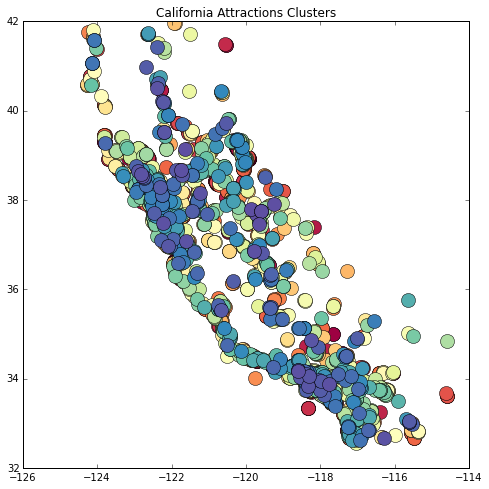

In [12]:
n_clusters_ = len(set(label_copy))
unique_labels_copy = set(label_copy)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_copy)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels_copy, colors):
    class_member_mask = (label_copy == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.title('California Attractions Clusters')
plt.show()

In [262]:
x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.2861, lng=-119.7394, map_type="roadmap", zoom=6, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")

plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="California: small clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (np.floor(50+25*r), np.floor(20+30*g), 200) for r,g in zip(cluster_nn,cluster_nn)
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


In [152]:
attractions['ClusterNum'] = label_copy.tolist()
attractions['City']=attractions.apply(lambda row: pattern.findall(row.RegionNameLong)[0], axis=1)
clusters_df['City']=clusters_df.apply(lambda row: (attractions.City[attractions.ClusterNum==row.ClusterNum]).max(), axis=1)

get wikipedia links for attractions

In [269]:
import wikipedia

def GetWikiUrl(lat,lon,title):
    results = wikipedia.geosearch(latitude=lat, longitude=lon, 
                                    title=title,results=10, radius=100)
    if len(results)>0:
        try:
            return wikipedia.page(results).url
        except:
            return ''
    else:
        return ''

attractions['Wiki']=attractions.apply(lambda row: GetWikiUrl(lon=row.Longitude,
                                                               lat=row.Latitude,
                                                               title=row.RegionName), axis=1)

/usr/local/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [291]:
attractions['Crime']=attractions.apply(lambda row: ViolentCrimeCount(lon=row.Longitude,
                                                               lat=row.Latitude,
                                                               radius=0.5), axis=1)

## Get hotels

In [153]:
sql = "Select EANHotelID,Name,LowRate,HighRate,StarRating,Latitude,Longitude,City " +\
      "From USproperties WHERE StateProvince='CA';"
hotels = DataFrame(psql.read_sql(sql, conn))

add crime data

In [268]:
hotels['Crime']=hotels.apply(lambda row: ViolentCrimeCount(lon=row.Longitude,
                                                               lat=row.Latitude,
                                                               radius=0.5), axis=1)

## Create objects count for each cluster

In [154]:
from collections import Counter
col_names=list(unique(attractions.SubClassification))
col_names.append('ClusterNum')
col_names
clustersobjects_df=DataFrame(columns=col_names)

In [155]:
for index, row in clusters_df.iterrows():
    type_list=list((attractions[attractions.ClusterNum==row.ClusterNum])['SubClassification'])
    dc = dict(Counter( type_list ))
    dc['ClusterNum'] = row.ClusterNum
    clustersobjects_df=clustersobjects_df.append(dc,ignore_index=True)
clustersobjects_df=clustersobjects_df.fillna(0)

In [182]:
clustersobjects_df
print

## Create commute time matrix
Call Google directions API to get the commute time between the hotels and attraction clusters within the same city

In [212]:
def TransitTime(hotel_lat,hotel_lon,cluster_lat,cluster_lon):
    url="https://maps.googleapis.com/maps/api/directions/json?origin="+\
        str(hotel_lat)+","+str(hotel_lon)+\
        "&destination="+str(cluster_lat)+","+str(cluster_lon)+\
        "&mode=transit&key="+keys.google_key
    json_s=json.loads(scraperwiki.scrape(url))
    try:
        value_ret=json_s['routes'][0]['legs'][0]['duration']['value']
    except:
        value_ret=TransitTimeDrive(hotel_lat,hotel_lon,cluster_lat,cluster_lon)
    return value_ret

def TransitTimeDrive(hotel_lat,hotel_lon,cluster_lat,cluster_lon):
    url="https://maps.googleapis.com/maps/api/directions/json?origin="+\
        str(hotel_lat)+","+str(hotel_lon)+\
        "&destination="+str(cluster_lat)+","+str(cluster_lon)+\
        "&mode=driving&key="+keys.google_key
    json_s=json.loads(scraperwiki.scrape(url))
    try:
        value_ret=json_s['routes'][0]['legs'][0]['duration']['value']
    except:
        value_ret=0
    return value_ret*3

In [ ]:
#commutetime_df=DataFrame(columns=['EANHotelID','ClusterNum','CommuteTime','City'])

In [234]:
unique_cities=unique(hotels.City)
#cities_left=unique_cities[unique(hotels.City)>='San Diego']
cities_left=unique_cities
for city in cities_left:
    local_hotels=hotels[hotels.City==city]
    local_clusters=clusters_df[clusters_df.City==city]
    for index,hotel in local_hotels.iterrows():
        for index,cluster in local_clusters.iterrows():
            commute_t=TransitTime(hotel.Latitude,hotel.Longitude,cluster.Latitude,cluster.Longitude)
            commutetime_df1=commutetime_df1.append({'EANHotelID':hotel.EANHotelID,
                                                   'ClusterNum':cluster.ClusterNum,
                                                   'CommuteTime':commute_t,
                                                   'City':city},ignore_index=True)
            

In [243]:
commutetime_df1
print

# Now let's put it all in a database

In [272]:
con = MySQLdb.connect(user="root", host="localhost",unix_socket="/tmp/mysql.sock")
cur = con.cursor()

In [273]:
cur.execute('CREATE DATABASE Illseeitall;')

ProgrammingError: (1007, "Can't create database 'Illseeitall'; database exists")

In [274]:
cur.execute('USE Illseeitall;')

0L

In [275]:
attractions.to_sql(con=con, name='attractions', if_exists='replace', flavor='mysql',index=False)
clustersobjects_df.to_sql(con=con, name='clustersobjects', if_exists='replace', flavor='mysql',index=False)
hotels['Name'] =  hotels.Name.str.replace('[^\x00-\x7F]','')
hotels.to_sql(con=con, name='hotels', if_exists='replace', flavor='mysql',index=False)
clusters_df.to_sql(con=con, name='clusters', if_exists='replace', flavor='mysql',index=False)
commutetime_df1.to_sql(con=con, name='commutetime', if_exists='replace', flavor='mysql',index=False)

KeyboardInterrupt: 

In [ ]:
cur.close()
con.close()

and, just to be safe, write as csv

In [ ]:
commutetime_df1.to_csv("commutetime_df1.csv", sep=',',encoding='utf-8')
attractions.to_csv("attractions.csv", sep=',',encoding='utf-8')
clustersobjects_df.to_csv("clustersobjects_df.csv", sep=',',encoding='utf-8')
hotels.to_csv("hotels.csv", sep=',',encoding='utf-8')
clusters_df.to_csv("clusters_df.csv", sep=',',encoding='utf-8')

In [292]:
attractions

,RegionID,RegionName,RegionNameLong,Latitude,Longitude,SubClassification,TimeStamp,ClusterNum,City,Wiki,Crime
0,6239232,20 Mule Team Museum,"20 Mule Team Museum, Boron, California, United...",34.999574,-117.650608,museums,2015-09-17 08:54:45,0,Boron,,15
1,6162746,20th Century Fox Studio,"20th Century Fox Studio, Los Angeles, Californ...",34.050027,-118.410649,amusement,2015-09-17 08:54:45,1,Los Angeles,,5
2,6200847,29 Palms Historical Society,"29 Palms Historical Society, Twentynine Palms,...",34.130528,-116.047441,museums,2015-09-17 08:54:45,2,Twentynine Palms,,10
3,6065734,555 California Street,"555 California Street, San Francisco, Californ...",37.792524,-122.403992,monument,2015-09-17 08:54:45,4,San Francisco,https://en.wikipedia.org/wiki/555_California_S...,3
4,6203149,77 Geary Galleries,"77 Geary Galleries, San Francisco, California,...",37.787850,-122.404730,museums,2015-09-17 08:54:45,4,San Francisco,,3
5,6263555,A Noise Within,"A Noise Within, Pasadena, California, United S...",34.149380,-118.082417,theater,2015-09-17 08:54:45,6,Pasadena,https://en.wikipedia.org/wiki/A_Noise_Within,5
6,6151905,Academy of Art University,"Academy of Art University, San Francisco, Cali...",37.787721,-122.400828,school,2015-09-17 08:54:45,4,San Francisco,https://en.wikipedia.org/wiki/Academy_of_Art_U...,3
7,6268825,Adagio Galleries,"Adagio Galleries, Palm Desert, California, Uni...",33.719790,-116.385908,museums,2015-09-17 08:54:45,7,Palm Desert,,8
8,6184976,Adelanto Branch Library,"Adelanto Branch Library, Adelanto, California,...",34.579189,-117.414452,cityscape,2015-09-17 08:54:45,8,Adelanto,,6
9,6177513,Adelanto Chamber of Commerece,"Adelanto Chamber of Commerece, Adelanto, Calif...",34.535312,-117.402182,cityscape,2015-09-17 08:54:45,9,Adelanto,,8


In [295]:
con = MySQLdb.connect(user="root", host="localhost",unix_socket="/tmp/mysql.sock")
cur = con.cursor()
cur.execute('USE Illseeitall;')
cur.execute('DROP TABLE attractions;')

0L

In [296]:
attractions.to_sql(con=con, name='attractions', if_exists='replace', flavor='mysql',index=False)

In [289]:
hotels.to_sql(con=con, name='hotels', if_exists='replace', flavor='mysql',index=False)

In [288]:
hotels

,EANHotelID,Name,LowRate,HighRate,StarRating,Latitude,Longitude,City,Crime
0,105304,Hyatt Regency Century Plaza,239.0000,472.0000,4.0,34.05819,-118.41564,Los Angeles,4
1,105310,The Westin St Francis on Union Square,233.3756,308.3544,4.0,37.78773,-122.40822,San Francisco,3
2,105319,The Westin South Coast Plaza,204.0000,239.0000,4.0,33.69022,-117.88473,Costa Mesa,4
3,105342,The Westin Bonaventure Hotel and Suites,238.9948,332.7183,4.0,34.05290,-118.25649,Los Angeles,4
4,105384,Courtyard by Marriott Los Angeles Westside,157.2182,273.2857,3.0,33.98146,-118.39184,Culver City,2
5,105386,Beverly Hills Marriott,242.7480,759.0000,3.5,34.05621,-118.39601,Los Angeles,3
6,105441,Quail Lodge & Golf Club,600.0000,775.0000,3.0,36.53258,-121.85085,Carmel,37
7,105457,Days Inn & Suites San Diego - SDSU,42.4900,69.9900,2.0,32.76811,-117.03619,La Mesa,17
8,105458,Red Roof Inn San Diego Downtown,79.0000,129.0000,2.0,32.71989,-117.15793,San Diego,17
9,105490,Hyatt Santa Barbara,549.0000,609.0000,3.5,34.41786,-119.66950,Santa Barbara,6
